In [82]:
!pip install numpy
!pip install seaborn
!pip install sklearn
!pip install matplotlib

You should consider upgrading via the 'c:\users\lvi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lvi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lvi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lvi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# Imports

In [1]:
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

METADATA_FILE_PATH = "census_income_metadata.txt"
TRAIN_FILE_PATH = "census_income_learn.csv"
TEST_FILE_PATH = "census_income_test.csv"
COLUMNS_PATH = "columns.json"

# Creation des dataframes de train et de test

In [2]:
def load_columns(path):
    with open(path, 'r') as f:
        return json.load(f)

def save_json(path, data):
    with open(path, 'w') as f:
        json.dump(data, f, indent=4)

# def get_column_names(path):
#     with open(path) as f:
#         lines = f.readlines()[23:68]
#         column_names = [line.split('\t')[-1].strip() for line in lines]
#         column_names += ["YEAR", "INCOME"]
#         remove_columns = ["AGI", "FEDTAX", "PEARNVAL", "PTOTVAL", "TAXINC"]
#         column_names = [column for column in column_names if column not in remove_columns]
#         return column_names

# def get_column_values(path):
#     with open(path) as f:
#         lines = f.readlines()[142:183]
#         column_values = np.array([line.split(': ') for line in lines])
#         columns, values = column_values[:,0], column_values[:,1]

#         values = [[re.sub(r"[.\n]", '', string) for string in value.split(', ')] for value in values if value != ""]
#         return dict(zip(columns, values))

def get_categorical_columns(columns):
    categorical_columns = []
    for key, value in columns.items():
        if key not in ["ADTIND", "ADTOCC", "SEOTR", "VETYN", "YEAR", "INCOME"] and value != ["continuous"]:
            categorical_columns.append(key)
    return categorical_columns

# column_names = get_column_names(path=METADATA_FILE_PATH)
# column_values = get_column_values(path=METADATA_FILE_PATH)
columns = load_columns(path=COLUMNS_PATH)
categorical_columns = get_categorical_columns(columns)

In [13]:
column_names = list(columns.keys()) + ["INCOME"]
train = pd.read_csv(TRAIN_FILE_PATH, sep=', ', names=column_names, na_values=["?"], engine="python").dropna()
test = pd.read_csv(TEST_FILE_PATH, sep=', ', names=column_names, na_values=["?"], engine="python").dropna()

train = train.drop(["MARSUPWT"], axis=1)
test = test.drop(["MARSUPWT"], axis=1)
train.shape, test.shape

((94462, 41), (47082, 41))

In [14]:
train

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,INCOME
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199509,47,Local government,43,12,Doctorate degree(PhD EdD),0,Not in universe,Married-civilian spouse present,Education,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,50000+.
199510,25,Private,33,41,Some college but no degree,0,Not in universe,Never married,Retail trade,Handlers equip cleaners etc,...,United-States,Germany,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
199514,51,Private,33,19,10th grade,0,Not in universe,Widowed,Retail trade,Sales,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
199516,3,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


# Plot de quelques valeurs du dataset

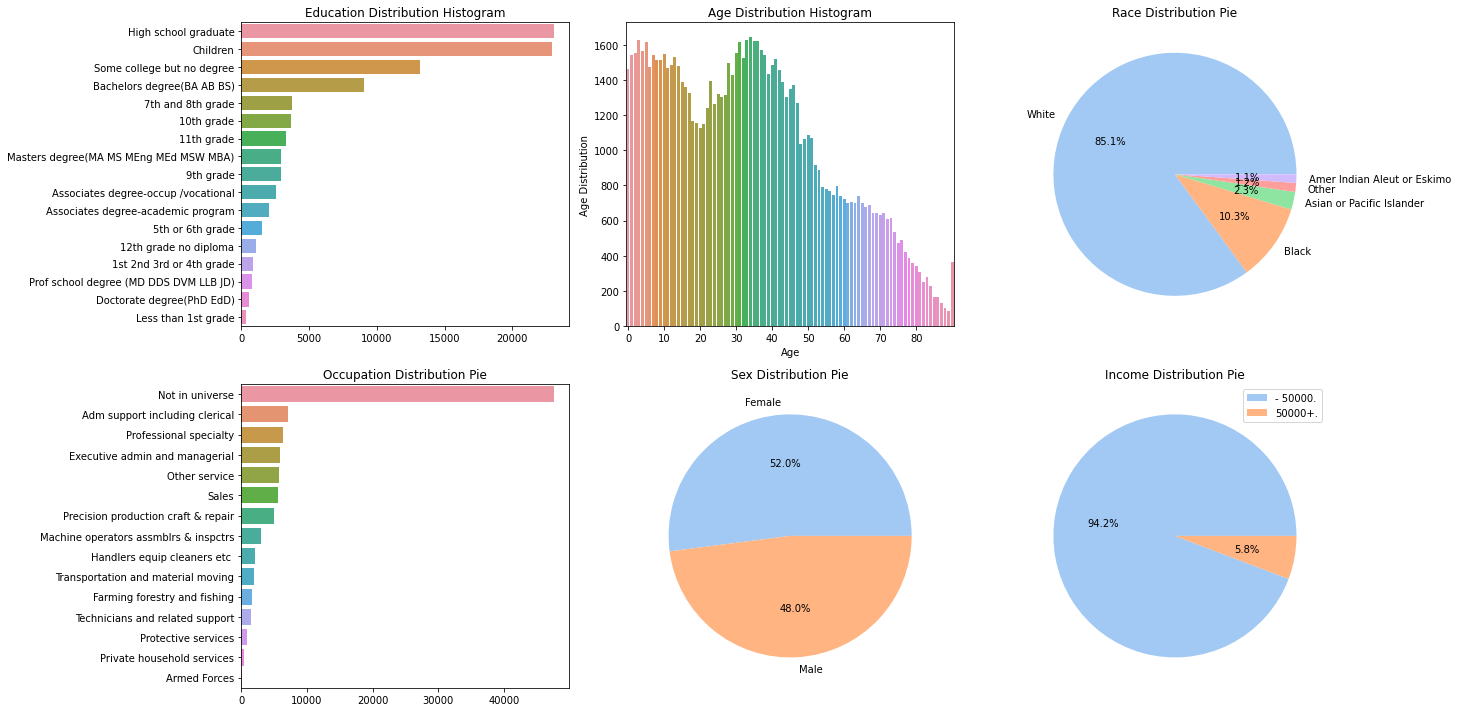

In [80]:
plt.figure(figsize=(20, 10))
colors = sns.color_palette('pastel')

# Age distribution
ax = plt.subplot(232)
age_count = train.AAGE.value_counts()
sns.barplot(x=age_count.index, y=age_count.values)
min_tick, max_tick = np.min(age_count.index), np.max(age_count.index)
plt.xticks(range(min_tick, max_tick, 10))
ax.set_xlabel("Age")
ax.set_ylabel("Age Distribution")
ax.set_title("Age Distribution Histogram")

# Education Distribution
ax = plt.subplot(231)
education_count = train.AHGA.value_counts()
sns.barplot(x=education_count.values, y=education_count.index)
ax.set_title("Education Distribution Histogram")

# Race Distribution
ax = plt.subplot(233)
race_counts = train.ARACE.value_counts()
ax.pie(race_counts, labels=race_counts.index, colors=colors, autopct='%.1f%%')
ax.set_title("Race Distribution Pie")

# Sex Distribution
ax = plt.subplot(235)
sex_counts = train.ASEX.value_counts()
ax.pie(sex_counts, labels=sex_counts.index, colors=colors, autopct='%.1f%%')
ax.set_title("Sex Distribution Pie")

# Occupation Distribution
ax = plt.subplot(234)
occupation_counts = train.AMJOCC.value_counts()
sns.barplot(x=occupation_counts.values, y=occupation_counts.index)
ax.set_title("Occupation Distribution Pie")

# Income Distribution
ax = plt.subplot(236)
income_counts = train.INCOME.value_counts()
ax.pie(income_counts, labels=income_counts.index, labeldistance=None, colors=colors, autopct='%.1f%%')
ax.set_title("Income Distribution Pie")
ax.legend()

plt.tight_layout()
plt.show()

# Affichage des correlations

En affichant les correlations des valeurs numériques, on peut remarquer quelques liens assez logiques de notre dataset. On a par exemple des paramètres comme l'âge (AAGE) et les bénéfices attribués au vétérans (VETYN) qui semblent étroitement liés, ou encore le type d'industrie (ADTIND) ainsi que le nombre de semaine de travail dans l'année (WKSWORK), etc...
Même si ces liens peuvent sembler assez évidents, cette heatmap montre qu'ils sont tout de même présents dans le dataset. Ce dernier semble donc très représentatif de ce que l'on retrouve en dans notre quotidien.

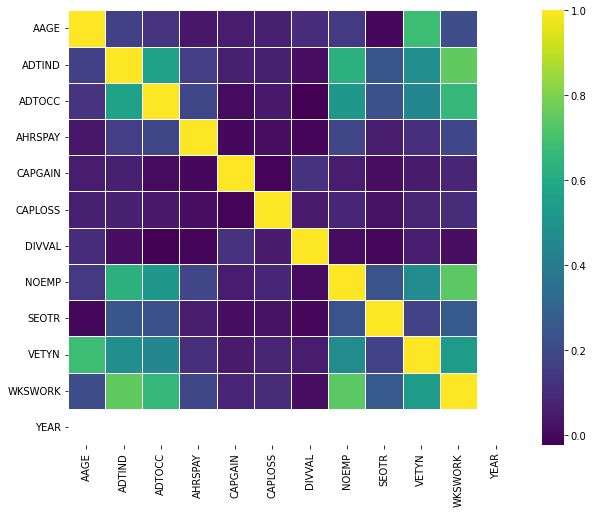

In [100]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), linewidths=.8, cmap="viridis")
plt.show()

# Séparation des datasets entre les données et les labels

In [87]:
value_list = sorted({x for v in columns.values() for x in v})
encoder = LabelEncoder().fit(value_list)

train_X = train.iloc[:,0:-2]
train_X[categorical_columns] = train_X[categorical_columns].apply(encoder.transform)
train_y = train.iloc[:,-1]

test_X = test.iloc[:,0:-2]
test_X[categorical_columns] = test_X[categorical_columns].apply(encoder.transform)
test_y = test.iloc[:,-1]

In [102]:
clf = LogisticRegression()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

C:\Users\lvi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9512340172465061